# ベイジアンネットワークの実装
PRML下巻（P.89）の3変数のベイジアンネットワークをpgmpyを使って実装する。

<img src='./image1.png'>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx

from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianModel

%matplotlib inline

## モデル定義

In [2]:
# ベイジアンネットワークの構造
model = BayesianModel([
    # ('親ノード', '子ノード')
    ('battery', 'gauge'),
    ('fuel', 'gauge'),
])

In [3]:
# 条件付き確率
battery_cpd = TabularCPD(
    variable='battery',
    variable_card=2,
    # values[0]: empty, values[1]: full
    values=[[.1], [.9]])
print(battery_cpd)

+------------+-----+
| battery(0) | 0.1 |
+------------+-----+
| battery(1) | 0.9 |
+------------+-----+


In [4]:
fuel_cpd = TabularCPD(
    variable='fuel',
    variable_card=2,
    # values[0]: empty, values[1]: full
    values=[[.1], [.9]])
print(fuel_cpd)

+---------+-----+
| fuel(0) | 0.1 |
+---------+-----+
| fuel(1) | 0.9 |
+---------+-----+


In [5]:
# valuesの与え方は以下のドキュメント参照
# https://pgmpy.org/models.html#module-pgmpy.models.BayesianModel
gauge_cpd = TabularCPD(
    variable='gauge',
    variable_card=2,
    values = [[.9, .8, .8, .2],
             [.1, .2, .2, .8]],
    evidence = ['battery', 'fuel'],
    evidence_card=[2, 2]
)
print(gauge_cpd)

+----------+------------+------------+------------+------------+
| battery  | battery(0) | battery(0) | battery(1) | battery(1) |
+----------+------------+------------+------------+------------+
| fuel     | fuel(0)    | fuel(1)    | fuel(0)    | fuel(1)    |
+----------+------------+------------+------------+------------+
| gauge(0) | 0.9        | 0.8        | 0.8        | 0.2        |
+----------+------------+------------+------------+------------+
| gauge(1) | 0.1        | 0.2        | 0.2        | 0.8        |
+----------+------------+------------+------------+------------+


In [6]:
# CPDをモデルに与える
model.add_cpds(battery_cpd, fuel_cpd, gauge_cpd)

# CPDを与えたモデルが有効かチェック
model.check_model()

True

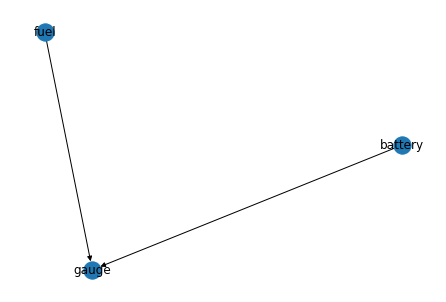

In [16]:
# モデルの構造可視化
nx.draw(model, with_labels=True)
plt.show()

In [8]:
# 独立しているノードを確認
model.get_independencies()

(battery _|_ fuel)
(fuel _|_ battery)

## 推論

In [9]:
model_infer = VariableElimination(model)

In [10]:
# 確認
battery_prob = model_infer.query(variables=['battery'])
print(battery_prob)

fuel_prob = model_infer.query(variables=['fuel'])
print(fuel_prob)

Eliminating: battery: 100%|██████████| 2/2 [00:00<00:00, 409.68it/s]

+------------+----------------+
| battery    |   phi(battery) |
+============+================+
| battery(0) |         0.1000 |
+------------+----------------+
| battery(1) |         0.9000 |
+------------+----------------+
+---------+-------------+
| fuel    |   phi(fuel) |
+=========+=============+
| fuel(0) |      0.1000 |
+---------+-------------+
| fuel(1) |      0.9000 |
+---------+-------------+


In [11]:
battery_fuel_prob = model_infer.query(variables=['battery', 'fuel', 'gauge'])
print(battery_fuel_prob)

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------+------------+----------+---------------------------+
| fuel    | battery    | gauge    |   phi(fuel,battery,gauge) |
+=========+============+==========+===========================+
| fuel(0) | battery(0) | gauge(0) |                    0.0090 |
+---------+------------+----------+---------------------------+
| fuel(0) | battery(0) | gauge(1) |                    0.0010 |
+---------+------------+----------+---------------------------+
| fuel(0) | battery(1) | gauge(0) |                    0.0720 |
+---------+------------+----------+---------------------------+
| fuel(0) | battery(1) | gauge(1) |                    0.0180 |
+---------+------------+----------+---------------------------+
| fuel(1) | battery(0) | gauge(0) |                    0.0720 |
+---------+------------+----------+---------------------------+
| fuel(1) | battery(0) | gauge(1) |                    0.0180 |
+---------+------------+----------+---------------------------+
| fuel(1) | battery(1) | gauge(0) |     

In [12]:
gauge_prob = model_infer.query(variables=['gauge'])
print(gauge_prob)

Eliminating: battery: 100%|██████████| 2/2 [00:00<00:00, 530.72it/s]

+----------+--------------+
| gauge    |   phi(gauge) |
+==========+==============+
| gauge(0) |       0.3150 |
+----------+--------------+
| gauge(1) |       0.6850 |
+----------+--------------+


### P(fuel|gauge=0)を求める

<img src='./image2.png'>

In [13]:
fuel0_prob_given_gauge0 = model_infer.query(variables=['fuel'], evidence={'gauge': 0})
print(fuel0_prob_given_gauge0)

Eliminating: battery: 100%|██████████| 1/1 [00:00<00:00, 402.45it/s]

+---------+-------------+
| fuel    |   phi(fuel) |
+=========+=============+
| fuel(0) |      0.2571 |
+---------+-------------+
| fuel(1) |      0.7429 |
+---------+-------------+


In [14]:
print(fuel0_prob_given_gauge0.values[0])

0.2571428571428572


### P(fuel|gauge=0, battery=0)を求める

<img src='./image3.png'>

In [15]:
fuel0_prob_given_gauge0_battery0 = model_infer.query(variables=['fuel'], evidence={'gauge': 0, 'battery': 0})
print(fuel0_prob_given_gauge0_battery0)

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------+-------------+
| fuel    |   phi(fuel) |
+=========+=============+
| fuel(0) |      0.1111 |
+---------+-------------+
| fuel(1) |      0.8889 |
+---------+-------------+
